In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/8_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/e09792da7efd49445895597ca6a3e4_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/export--2049457206_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/export--2049457166_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/ec633a79e6f5f1916987633ea36db9_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/export--2049457205_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/export--2049457168_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/export--2049457202_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/downloaded_image20211019-1658-1o19lwb_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/a93ab7bef1bedc9c49219ef6b9c361_big_gallery.jpeg
/kaggle/input/brain-tumor-mri-images-44c/Papiloma T2/cb802acf0b48fc39914

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
data_path = '/kaggle/input/brain-tumor-mri-images-44c'

In [4]:
def main(data_path):
    filepaths = []
    labels = []
    classes_list = sorted(os.listdir(data_path))

    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(data_path, s_class)
        flist = sorted(os.listdir(classpath))
        
        for file in flist:
            file_path = os.path.join(classpath, file)
            filepaths.append(file_path)
            labels.append(label)

    train_df = pd.DataFrame({
        'image_path': filepaths,
        'label': labels
    })
    
    return train_df

In [5]:
data_df = main(data_path)
data_df.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
1,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
2,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
3,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
4,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1


In [6]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 44 classes
We have 4479 images


In [7]:
data_df['label'].value_counts()

Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Astrocitoma T1C+          233
Meningioma T2             233
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            112
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       86
Tuberculoma T1C+           84
Carcinoma T2               73
Oligodendroglioma T1C+     72
Meduloblastoma T1C+        67
Papiloma T1                66
Oligodendroglioma T2       66
Carcinoma T1               66
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinoma T1C+             40
Tuberculom

In [8]:
import plotly.express as px
import plotly.graph_objs as go

def count_plot(x, title, xlabel, ylabel, width, length, order, rotation=True, palette='winter'):
    
    fig = px.histogram(x=x, color_discrete_sequence=px.colors.qualitative.Plotly, 
                       color=x, nbins=len(set(x)), template='simple_white')
    
    fig.update_layout(title=title, width=width, height=length, 
                      xaxis_title=xlabel, yaxis_title=ylabel,
                      font=dict(size=20))
    
    if rotation:
        fig.update_layout(xaxis_tickangle=-45)
    
    fig.show()

In [9]:
x = data_df['label']
order = x.value_counts().index
count_plot(x, "Labels distribution (Train Data)", "Label", 'Frequency', 800,600, order=order, rotation = True)

In [10]:
test_split_size = 0.3
train_df, test_df = train_test_split(data_df, test_size=test_split_size, shuffle=True, random_state=123, stratify=data_df['label'])
test_df, valid_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=123, stratify=test_df['label'])

In [11]:
train_df.head()

,image_path,label
2175,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1C+
1735,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1
1191,/kaggle/input/brain-tumor-mri-images-44c/Gliob...,Glioblastoma T1
129,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
1645,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1


In [12]:
test_df.head()

,image_path,label
3506,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,Schwannoma T1C+
1822,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1
3265,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T1C+
4371,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,_NORMAL T2
244,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1C+


In [13]:
valid_df.head()

,image_path,label
3652,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,Schwannoma T1C+
300,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1C+
481,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T2
4051,/kaggle/input/brain-tumor-mri-images-44c/_NORM...,_NORMAL T1
892,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma T1C+


In [14]:
print(f"We have {len(train_df)} images in the training dataset\nWe have {len(valid_df)} images in the validating dataset\nWe have {len(test_df)} images in the testing dataset")

We have 3135 images in the training dataset
We have 672 images in the validating dataset
We have 672 images in the testing dataset


In [15]:
x = train_df['label']
order = x.value_counts().index
count_plot(x, "Labels distribution (Train Data)", "Label", 'Frequency', 800,600, rotation = True, order=order)

In [16]:
x = test_df['label']
order = x.value_counts().index
count_plot(x, "Labels distribution (Test Data)", "Label", 'Frequency', 800,600, rotation = True, order=order)

In [17]:
x = valid_df['label']
order = x.value_counts().index
count_plot(x, "Labels distribution (Valid Data)", "Label", 'Frequency', 800,600, rotation = True, order=order)

In [18]:
def get_images_avg_width_height(df):
    
    avg_width, avg_height = 0,0
    for i in df.index:
        
        try:
            img_path = df['image_path'].loc[i]
            img = cv2.imread(img_path)
            avg_width += img.shape[0]
            avg_height += img.shape[1]
        except:
            pass

    avg_width // len(df)
    avg_height // len(df)
    
    return avg_width, avg_height

In [19]:
len(data_df)

4479

In [20]:
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
def scalar(img):
    return img

In [21]:
tr_gen = ImageDataGenerator(preprocessing_function= scalar, 
                            horizontal_flip= True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= color, 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= color, 
                                       shuffle= True, 
                                       batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, 
                                      x_col= 'image_path', 
                                      y_col= 'label', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= color, 
                                      shuffle= False, 
                                      batch_size= test_batch_size)


Found 3134 validated image filenames belonging to 44 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning:

Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.



Found 672 validated image filenames belonging to 44 classes.
Found 672 validated image filenames belonging to 44 classes.


In [22]:
class_count = len(list(train_gen.class_indices.keys())) 

In [23]:
base_model = tf.keras.applications.VGG19(include_top= False, weights= "imagenet", 
                                         input_shape= img_shape,pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                                 
Total params: 20,169,068
Trainable params: 20,168,044
Non

In [24]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                           verbose=1)

checkpoint = ModelCheckpoint('model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 100, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 8.1670 - accuracy: 0.1372
Epoch 1: val_loss improved from inf to 9.28165, saving model to model_weights.h5
98/98 [==============================] - 54s 358ms/step - loss: 8.1670 - accuracy: 0.1372 - val_loss: 9.2817 - val_accuracy: 0.1190
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 6.5583 - accuracy: 0.2313
Epoch 2: val_loss improved from 9.28165 to 6.33565, saving model to model_weights.h5
98/98 [==============================] - 27s 274ms/step - loss: 6.5583 - accuracy: 0.2313 - val_loss: 6.3357 - val_accuracy: 0.1920
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 5.6597 - accuracy: 0.2913
Epoch 3: val_loss improved from 6.33565 to 6.23476, saving model to model_weights.h5
98/98 [==============================] - 27s 275ms/step - loss: 5.6597 - accuracy: 0.2913 - val_loss: 6.2348 - val_accuracy: 0.1622
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss:

In [25]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

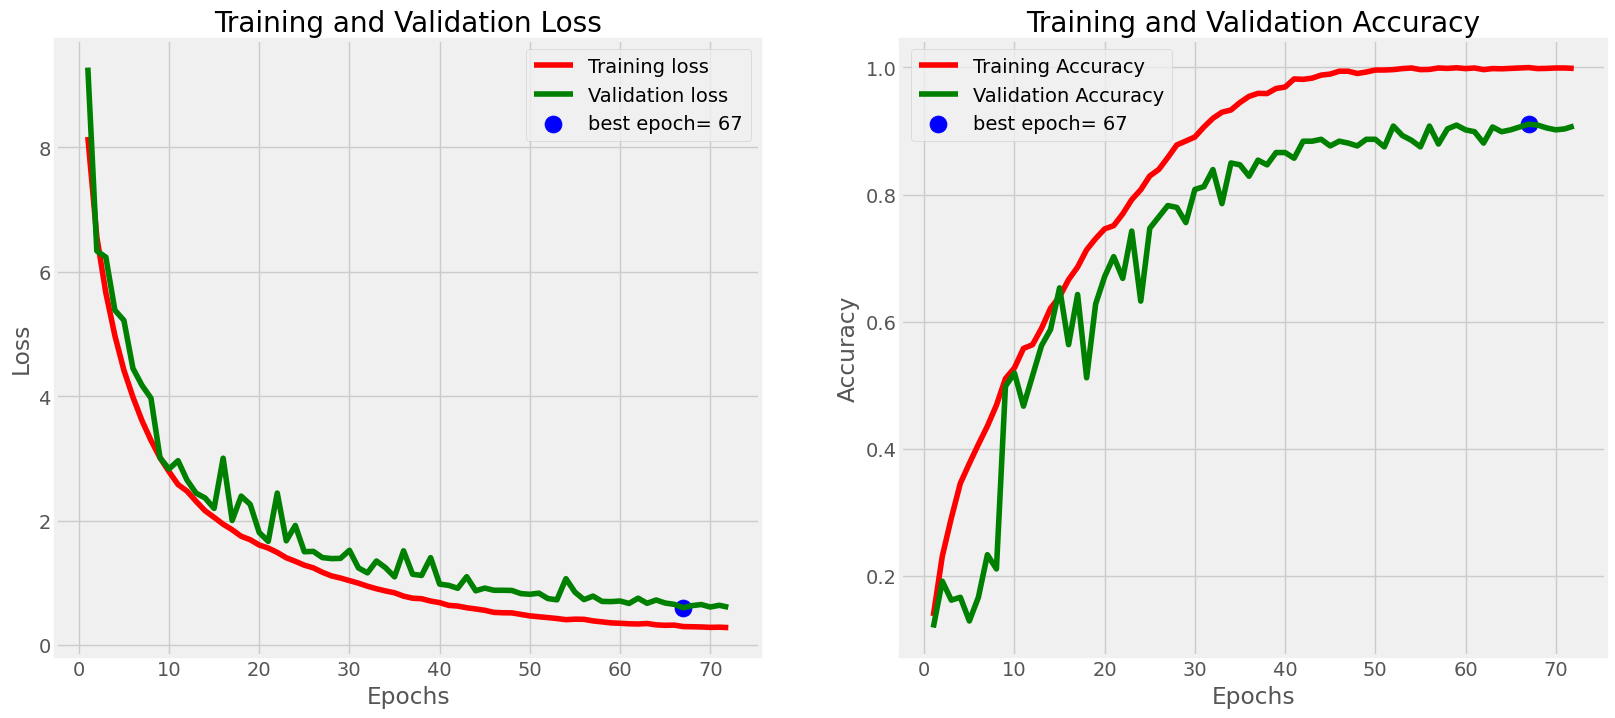

In [26]:
plot_training(history)

In [27]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

12/12 [==============================] - 11s 638ms/step - loss: 0.6925 - accuracy: 0.8795
Train Loss:  0.2621096968650818
Train Accuracy:  1.0
--------------------
Validation Loss:  0.6384114623069763
Validation Accuracy:  0.8958333134651184
--------------------
Test Loss:  0.6924880743026733
Test Accuracy:  0.8794642686843872


In [28]:
y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes

12/12 [==============================] - 3s 238ms/step


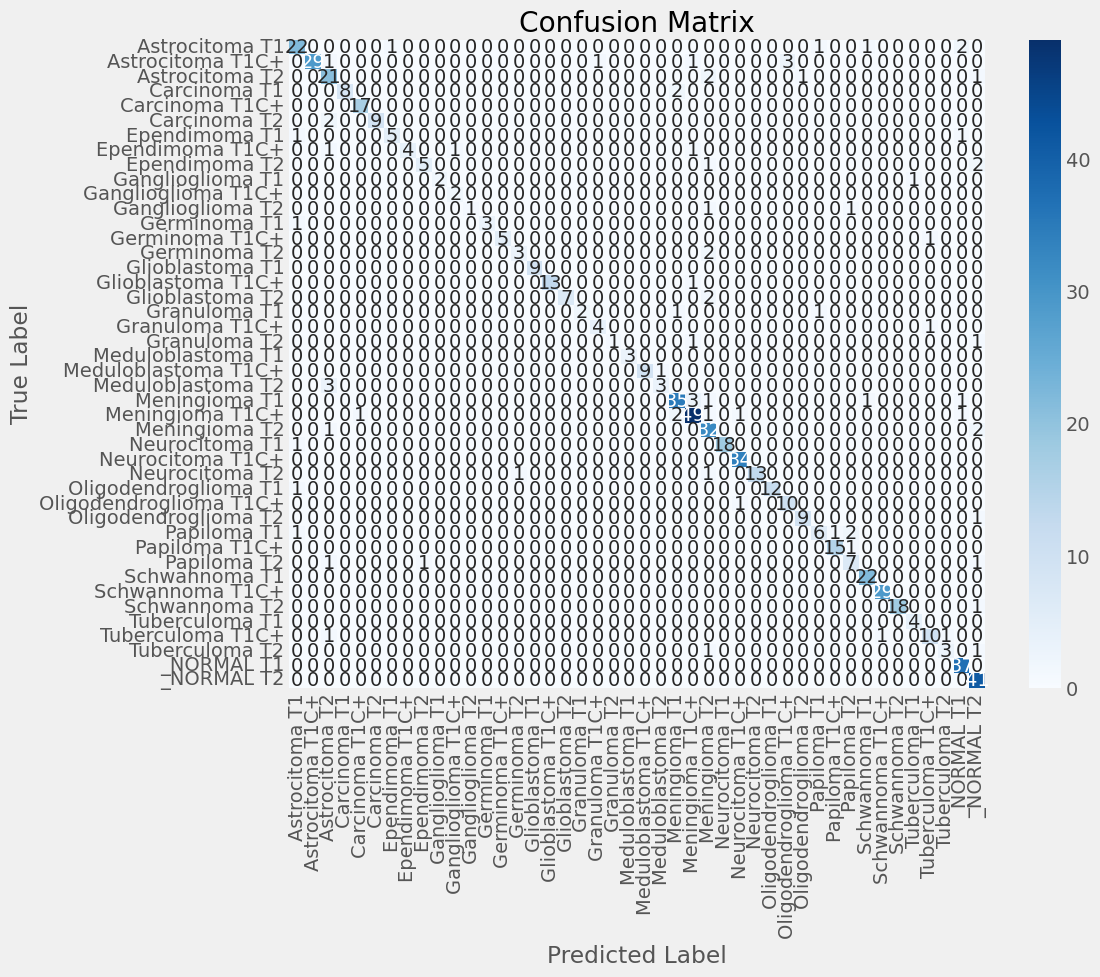

In [29]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report: ")
print(report)

Classification Report: 
                        precision    recall  f1-score   support

        Astrocitoma T1       0.81      0.81      0.81        27
      Astrocitoma T1C+       1.00      0.83      0.91        35
        Astrocitoma T2       0.68      0.84      0.75        25
          Carcinoma T1       1.00      0.80      0.89        10
        Carcinoma T1C+       0.94      1.00      0.97        17
          Carcinoma T2       1.00      0.82      0.90        11
         Ependimoma T1       0.83      0.71      0.77         7
       Ependimoma T1C+       1.00      0.57      0.73         7
         Ependimoma T2       0.83      0.62      0.71         8
      Ganglioglioma T1       1.00      0.67      0.80         3
    Ganglioglioma T1C+       0.67      1.00      0.80         2
      Ganglioglioma T2       1.00      0.33      0.50         3
          Germinoma T1       1.00      0.75      0.86         4
        Germinoma T1C+       1.00      0.83      0.91         6
          Germi

In [31]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report: ")
print(report)

Classification Report: 
                        precision    recall  f1-score   support

        Astrocitoma T1       0.81      0.81      0.81        27
      Astrocitoma T1C+       1.00      0.83      0.91        35
        Astrocitoma T2       0.68      0.84      0.75        25
          Carcinoma T1       1.00      0.80      0.89        10
        Carcinoma T1C+       0.94      1.00      0.97        17
          Carcinoma T2       1.00      0.82      0.90        11
         Ependimoma T1       0.83      0.71      0.77         7
       Ependimoma T1C+       1.00      0.57      0.73         7
         Ependimoma T2       0.83      0.62      0.71         8
      Ganglioglioma T1       1.00      0.67      0.80         3
    Ganglioglioma T1C+       0.67      1.00      0.80         2
      Ganglioglioma T2       1.00      0.33      0.50         3
          Germinoma T1       1.00      0.75      0.86         4
        Germinoma T1C+       1.00      0.83      0.91         6
          Germi

In [32]:
pip install inceptionv3

ERROR: Could not find a version that satisfies the requirement inceptionv3 (from versions: none)
ERROR: No matching distribution found for inceptionv3
Note: you may need to restart the kernel to use updated packages.


In [33]:
base_model1 = tf.keras.applications.InceptionV3(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape,
                                                               pooling= 'max')

model1 = Sequential([
    base_model1,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model1.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model1.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_95 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 44)                11308     
                                                                 
Total params: 22,346,828
Trainable params: 22,308,300
N

In [34]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                           verbose=1)

checkpoint = ModelCheckpoint('model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model1.fit(x= train_gen, 
                    epochs= 30, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/30
98/98 [==============================] - ETA: 0s - loss: 10.0711 - accuracy: 0.3631
Epoch 1: val_loss improved from inf to 13.28813, saving model to model_weights.h5
98/98 [==============================] - 62s 242ms/step - loss: 10.0711 - accuracy: 0.3631 - val_loss: 13.2881 - val_accuracy: 0.1458
Epoch 2/30
98/98 [==============================] - ETA: 0s - loss: 7.4328 - accuracy: 0.6720
Epoch 2: val_loss improved from 13.28813 to 7.10368, saving model to model_weights.h5
98/98 [==============================] - 18s 185ms/step - loss: 7.4328 - accuracy: 0.6720 - val_loss: 7.1037 - val_accuracy: 0.6518
Epoch 3/30
98/98 [==============================] - ETA: 0s - loss: 5.9390 - accuracy: 0.8111
Epoch 3: val_loss improved from 7.10368 to 5.34181, saving model to model_weights.h5
98/98 [==============================] - 19s 188ms/step - loss: 5.9390 - accuracy: 0.8111 - val_loss: 5.3418 - val_accuracy: 0.8363
Epoch 4/30
98/98 [==============================] - ETA: 0s - loss

In [35]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

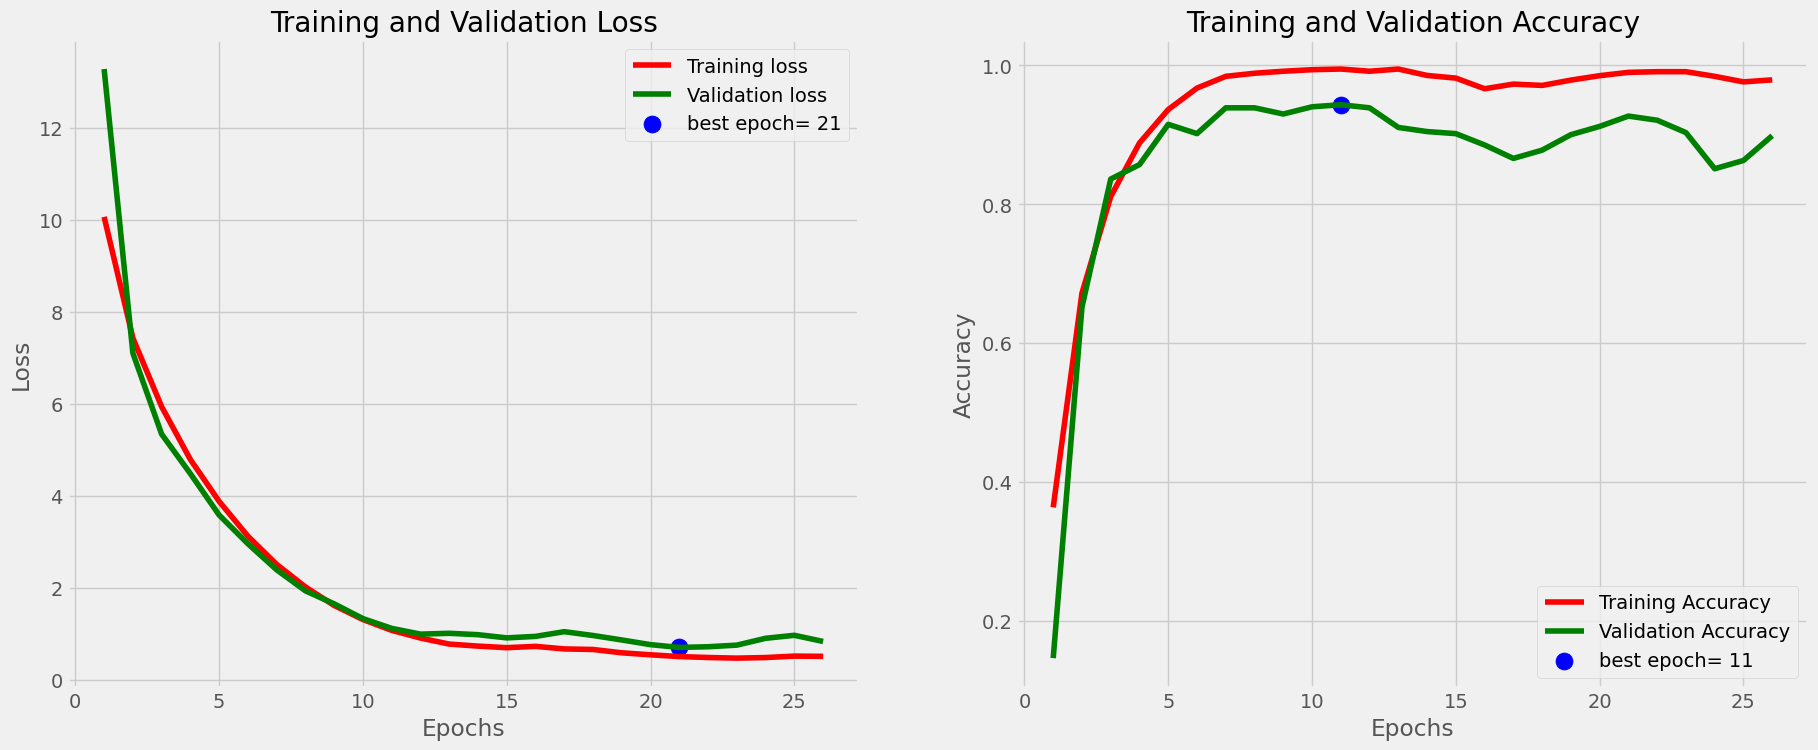

In [36]:
plot_training(history)

In [37]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model1.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model1.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model1.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

12/12 [==============================] - 4s 256ms/step - loss: 0.8996 - accuracy: 0.8795
Train Loss:  0.47951555252075195
Train Accuracy:  0.9765625
--------------------
Validation Loss:  0.8619298934936523
Validation Accuracy:  0.890625
--------------------
Test Loss:  0.8995938301086426
Test Accuracy:  0.8794642686843872


In [38]:
y_pred = model1.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes

12/12 [==============================] - 4s 236ms/step


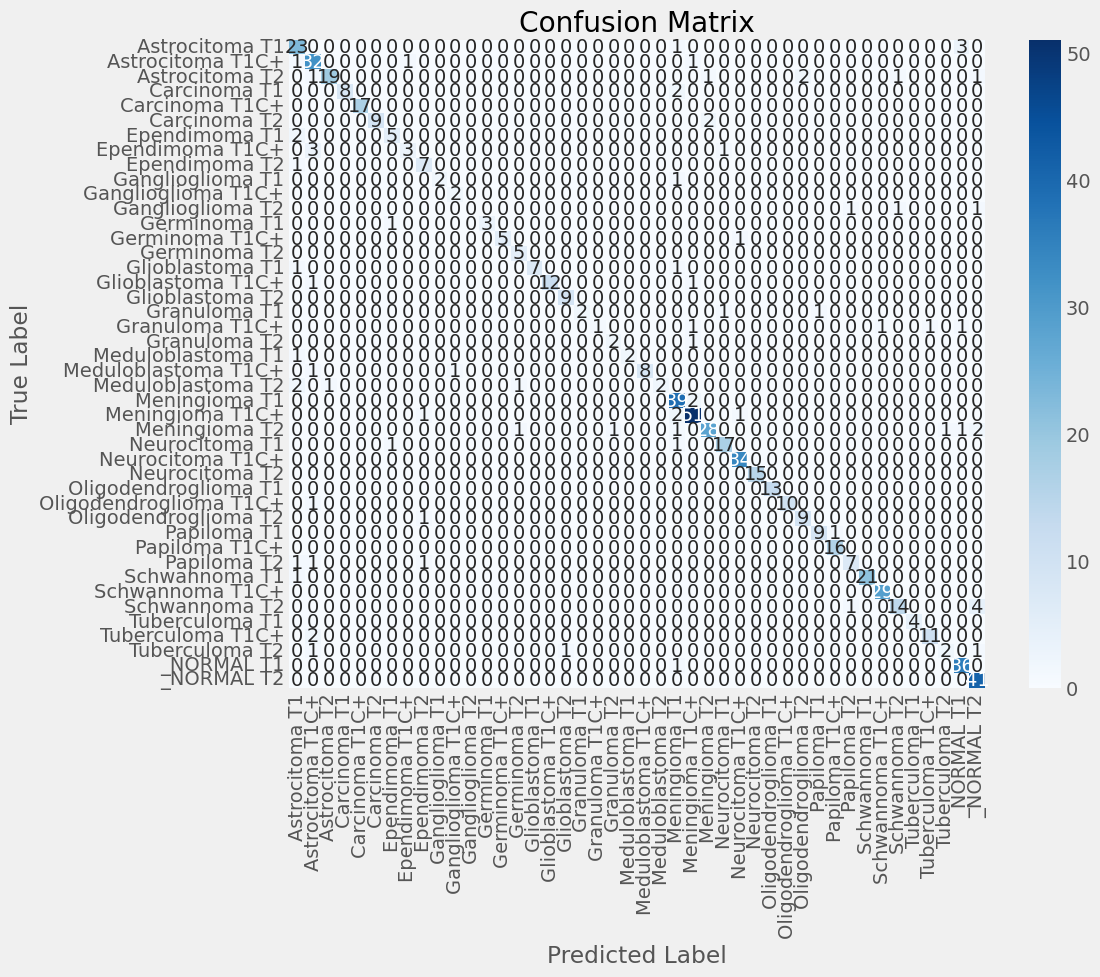

In [39]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [40]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report: ")
print(report)

Classification Report: 
                        precision    recall  f1-score   support

        Astrocitoma T1       0.70      0.85      0.77        27
      Astrocitoma T1C+       0.74      0.91      0.82        35
        Astrocitoma T2       0.95      0.76      0.84        25
          Carcinoma T1       1.00      0.80      0.89        10
        Carcinoma T1C+       1.00      1.00      1.00        17
          Carcinoma T2       1.00      0.82      0.90        11
         Ependimoma T1       0.71      0.71      0.71         7
       Ependimoma T1C+       0.75      0.43      0.55         7
         Ependimoma T2       0.70      0.88      0.78         8
      Ganglioglioma T1       1.00      0.67      0.80         3
    Ganglioglioma T1C+       0.67      1.00      0.80         2
      Ganglioglioma T2       0.00      0.00      0.00         3
          Germinoma T1       1.00      0.75      0.86         4
        Germinoma T1C+       1.00      0.83      0.91         6
          Germi

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

